In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from agent import Agent, advanced_random_policy, random_policy, advanced_policy_nD, sarsa
from game import Game
import matplotlib.pyplot as plt
import numpy as np

### In a first time, we train an agent for 2D tic-tac-toe using our modified SARSA algorithm

In [ ]:
%%time
game = Game(None, None, n_dim=2, size=3)
agent = Agent(size=3)

n_eps = 20000
# Trains agent with the advanced policy
sarsa(game, agent, advanced_random_policy, alpha=0.45, alpha_factor=0.9995**(10000/n_eps), gamma=0.7, epsilon=1.0, \
      epsilon_factor=0.9997**(10000/n_eps), r_win=11.0, r_lose=0.0, r_even=1.0, r_even2=1.25, num_episodes=20000)

We make our agent play 1000 games against the random policy

In [ ]:
random_opponent = Agent(size=3, policy=random_policy)
game = Game(agent, random_opponent, n_dim=2, size=3)

agent_1_win, oppo_2_win, agent_1_even, agent_2_win, oppo_1_win, agent_2_even = game.simulate_games(1000)
tot_agent_win = agent_1_win + agent_2_win
tot_agent_lose = oppo_1_win + oppo_2_win
tot_even = agent_1_even + agent_2_even
print("On 1000 games, agent won", tot_agent_win, "times, lost", tot_agent_lose, "times and made", tot_even, "even games.")

Now we make our agent play 1000 games against the advanced policy

In [ ]:
advanced_opponent = Agent(size=3, policy=advanced_random_policy)
game = Game(agent, advanced_opponent, n_dim=2, size=3)

agent_1_win, oppo_2_win, agent_1_even, agent_2_win, oppo_1_win, agent_2_even = game.simulate_games(1000)
tot_agent_win = agent_1_win + agent_2_win
tot_agent_lose = oppo_1_win + oppo_2_win
tot_even = agent_1_even + agent_2_even
print("On 1000 games, agent won", tot_agent_win, "times, lost", tot_agent_lose, "times and made", tot_even, "even games.")

We give the possibility to play against our agent

In [ ]:
game = Game(agent, "Human player", n_dim=2, size=3) # agent plays first
#game = Game("Human player", agent, n_dim=2, size=3) # to play first
game.play_a_game()

We can evaluate the performances of our agent depending on the number of training episodes

In [ ]:
win1, lose1, draw1, win2, lose2, draw2, n_eps = [], [], [], [], [], [], []
for n in [1, 10, 100, 200, 400, 700, 1000, 2000, 3000, 4000, 5000, 7000, 10000, 15000, 20000]:
    ar = 0.9995**(10000/n)
    er = 0.9997**(10000/n)
    agent = Agent(size=3)
    advanced_opponent = Agent(size=3, policy=advanced_random_policy)
    game = Game(agent, advanced_opponent, n_dim=2, size=3)
    sarsa(game, agent, random_policy, alpha=0.45, alpha_factor=ar, gamma=0.7, epsilon=1.0, epsilon_factor=er, \
          r_win=11.0, r_lose=0.0, r_even=1.0, r_even2=1.25, num_episodes=n)
    win_p1_a, win_p2_a, tot_even_a, win_p1_b, win_p2_b, tot_even_b = game.simulate_games(10000)
    win1.append(win_p1_a)
    win2.append(win_p1_b)
    lose1.append(win_p2_a)
    lose2.append(win_p2_b)
    draw1.append(tot_even_a)
    draw2.append(tot_even_b)
    n_eps.append(n)

Results when the agent plays in first

In [ ]:
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(0.6*6.4, 1*4.8))
plt.plot(n_eps, np.array(win1)/50, label='win')
plt.plot(n_eps, np.array(lose1)/50, label='lose')
plt.plot(n_eps, np.array(draw1)/50, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='large')
plt.ylabel('test games (in % on 5000 games)', fontsize='large')
plt.ylim(0, 105)
plt.title('Fig.(7) : Training with the random\npolicy and testing against the\nadvanced one (agent plays in first)')
plt.legend(loc='best', fontsize='large')
plt.savefig("plot1.pdf", bbox_inches='tight')

Results when the agent plays in second

In [ ]:
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(0.6*6.4, 1*4.8))
plt.plot(n_eps, np.array(win2)/50, label='win')
plt.plot(n_eps, np.array(lose2)/50, label='lose')
plt.plot(n_eps, np.array(draw2)/50, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='large')
plt.ylabel('test games (in % on 5000 games)', fontsize='large')
plt.ylim(0, 105)
plt.title('Fig.(8) : Training with the random\npolicy and testing against the\nadvanced one (agent plays in second)')
plt.legend(loc='best', fontsize='large')
plt.savefig("plot2.pdf", bbox_inches='tight')

### Now, we show our Policy Gradient model for 2D, 3D and 4D
We start by the 2D case

We train our model with 20 000 iteration and batch size of 1000

In [2]:
import neuralAgent as na
device = 'cuda' if torch.cuda.is_available() else 'cpu'

game = Game(None, None, n_dim=2, size=3)
agent1 = na.Model()
agent1, values, _, _, _ = na.train_network(agent1, game, 20000, 1000)
agent1.save()
print(values)

100%|██████████| 20000/20000 [03:46<00:00, 88.19it/s] 


[array(0.23419923, dtype=float32), array(0.23419923, dtype=float32), array(0.22808589, dtype=float32), array(0.22808589, dtype=float32), array(0.22612913, dtype=float32), array(0.22612913, dtype=float32), array(0.22326289, dtype=float32), array(0.22326289, dtype=float32), array(0.22426078, dtype=float32), array(0.22426078, dtype=float32), array(0.22625785, dtype=float32), array(0.22625785, dtype=float32), array(0.23372282, dtype=float32), array(0.23372282, dtype=float32), array(0.22258882, dtype=float32), array(0.22258882, dtype=float32), array(0.21420614, dtype=float32), array(0.21420614, dtype=float32), array(0.21538883, dtype=float32), array(0.21538883, dtype=float32), array(0.22042143, dtype=float32), array(0.22042143, dtype=float32), array(0.22978505, dtype=float32), array(0.22978505, dtype=float32), array(0.22079352, dtype=float32), array(0.22079352, dtype=float32), array(0.22579096, dtype=float32), array(0.22579096, dtype=float32), array(0.21501867, dtype=float32), array(0.21501

We make our agent play 1000 games and then 10000 against the random policy

In [ ]:
# Example of loading a saved agent
loaded_agent = na.Model()
loaded_agent.load()
wins, draw, loses = na.test_against_random(agent1, game, 1000)
print("Win {}, Draw {}, Loses {}".format(wins, draw, loses))

In [ ]:
wins, draw, loses = na.test_against_random(agent1, game, 10000)
print("Win {}, Draw {}, Loses {}".format(wins, draw, loses))

In [ ]:
game = Game(agent1, "Human player", n_dim=2, size=3) # agent plays first
#game = Game("Human player", agent1, n_dim=2, size=3) # to play first
game.play_a_game()

#### Now the 3D case 

In [ ]:
game = Game(None, None, n_dim=3, size=3)
agent1 = na.Model(3, 3)
agent1, values, _, _, _ = na.train_network(agent1, game, 10000, 1000)
#print(values)

We show its performances against the random policy

In [ ]:
wins, draw, loses = na.test_against_random(agent1, game, 1000)
print("Win {}, Draw {}, Loses {}".format(wins, draw, loses))

### Plots of performance evolution according to training episodes

2D case

100%|██████████| 5000/5000 [00:59<00:00, 84.34it/s] 


1
10
100
200
400
700
1000
2000
3000
4000
5000
7000
10000
15000
20000


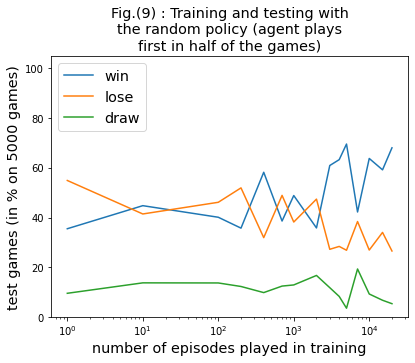

In [3]:
win1, lose1, draw1, n_eps = [], [], [], []
for n in [1, 10, 100, 200, 400, 700, 1000, 2000, 3000, 4000, 5000, 7000, 10000, 15000, 20000]:
    game = Game(None, None, n_dim=2, size=3)
    agent1 = na.Model()
    agent1, values, _, _, _ = na.train_network(agent1, game, n, 1000)
    wins, draw, loses = na.test_against_policy(agent1, game, random_policy, 5000)
    win1.append(wins)
    lose1.append(loses)
    draw1.append(draw)
    n_eps.append(n)
    print(n)
    
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(1*6.4, 1*4.8))
plt.plot(n_eps, np.array(win1)/50, label='win')
plt.plot(n_eps, np.array(lose1)/50, label='lose')
plt.plot(n_eps, np.array(draw1)/50, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='x-large')
plt.ylabel('test games (in % on 5000 games)', fontsize='x-large')
plt.ylim(0, 105)
plt.title('Fig.(9) : Training and testing with\nthe random policy (agent plays\nfirst in half of the games)', \
          fontsize='x-large')
plt.legend(loc='upper left', fontsize='x-large')
plt.savefig("plot1.pdf", bbox_inches='tight')

3D

In [4]:
win1, lose1, draw1, n_eps = [], [], [], []
win1Ad, lose1Ad, draw1Ad = [], [], []
for n in [1, 10, 100, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]:
    game = Game(None, None, n_dim=3, size=3)
    agent1 = na.Model(3, 3)
    agent1, values, _, _, _ = na.train_network(agent1, game, n, 1000, policy=advanced_policy_nD)
    wins, draw, loses = na.test_against_policy(agent1, game, random_policy, 1000)
    winsAd, drawAd, losesAd = na.test_against_policy(agent1, game, advanced_policy_nD, 1000)
    win1.append(wins)
    lose1.append(loses)
    draw1.append(draw)
    win1Ad.append(winsAd)
    lose1Ad.append(losesAd)
    draw1Ad.append(drawAd)
    n_eps.append(n)

100%|██████████| 1000/1000 [02:20<00:00,  7.12it/s]


Agent trained with the advanced policy and plays games against the random policy

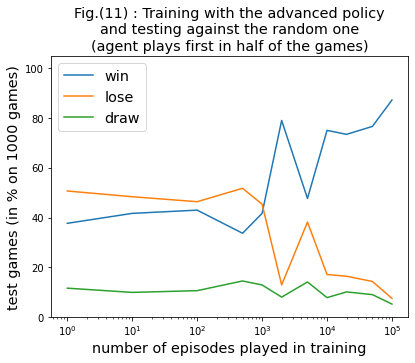

In [5]:
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(1*6.4, 1*4.8))
plt.plot(n_eps, np.array(win1)/10, label='win')
plt.plot(n_eps, np.array(lose1)/10, label='lose')
plt.plot(n_eps, np.array(draw1)/10, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='x-large')
plt.ylabel('test games (in % on 1000 games)', fontsize='x-large')
plt.ylim(0, 105)
plt.title('Fig.(11) : Training with the advanced policy\nand testing against the random one\n(agent plays first in half of the games)', \
          fontsize='x-large')
plt.legend(loc='best', fontsize='x-large')
plt.savefig("agent_vs_advanced_in_3D.pdf", bbox_inches='tight')

Agent trained with the advanced policy plays games against it

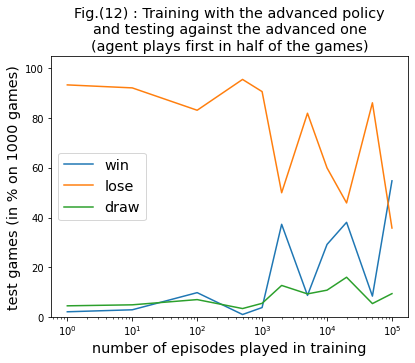

In [6]:
n_eps = np.array(n_eps)
fig = plt.figure(figsize=(1*6.4, 1*4.8))
plt.plot(n_eps, np.array(win1Ad)/10, label='win')
plt.plot(n_eps, np.array(lose1Ad)/10, label='lose')
plt.plot(n_eps, np.array(draw1Ad)/10, label='draw')
plt.xscale('log')
plt.xlabel('number of episodes played in training', fontsize='x-large')
plt.ylabel('test games (in % on 1000 games)', fontsize='x-large')
plt.ylim(0, 105)
plt.title('Fig.(12) : Training with the advanced policy\nand testing against the advanced one\n(agent plays first in half of the games)', \
          fontsize='x-large')
plt.legend(loc='best', fontsize='x-large')
plt.savefig("agent_vs_advanced_in_3D.pdf", bbox_inches='tight')